<a href="https://colab.research.google.com/github/iwatsuki-yuuki/LLM_lecture/blob/main/Prompting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2025年 大規模言語モデル基礎 推論（Prompting，In-context Learning） 演習
## 目次
- Transformersライブラリの基礎
- Decoding
    - Greedy Decoding, Top-p Sampling
- Prompting
    - Zero-shot / few-shot / CoT promptingでpromptingの効果を実感
- 発展的なプロンプティング・応用
    - LLM-as-a-Judge, Best-of-N

## Transformersライブラリの基礎
> Transformers は最先端の学習済みモデルを簡単にダウンロードして学習するAPIとツールを提供します。([Transformers公式ドキュメントより](https://huggingface.co/docs/transformers/ja/index))  

TransformersはHugging Face社が開発しているライブラリで、世界中の会社・個人が開発した様々なモデルを簡単に利用できるようにするためのツールキットです。皆さんが開発したモデルもTransformersライブラリを利用して公開することができます。


In [1]:
!pip install -q transformers accelerate matplotlib

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
# https://huggingface.co/openai-community/gpt2-xl
# modelの名前を決める
model_name = "gpt2-xl"
# トークンの前処理
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name,
).to('cuda')

text = "The capital of Japan is"
encoded_input = tokenizer(text, return_tensors='pt').to(model.device)
output = model.generate(
    **encoded_input,
    max_new_tokens=128,
    do_sample=True,
    temperature=0.7,
    top_p=0.5,
    )
print(tokenizer.decode(output[0]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The capital of Japan is Tokyo, and the capital of the United States is Washington, D.C.

The capital of the European Union is Brussels, and the capital of the United Kingdom is London.

The capital of the United States is Washington, D.C.

The capital of the European Union is Brussels, and the capital of the United Kingdom is London.

The capital of the United States is Washington, D.C.

The capital of the European Union is Brussels, and the capital of the United Kingdom is London.

The capital of the United States is Washington, D.C.

The capital


In [4]:
# Tokenizer
text = "The capital of Japan is"
print(text)
token_ids = tokenizer.encode(text)
print(token_ids)
for token_id in token_ids:
    print(f"{token_id}: {repr(tokenizer.decode([token_id]))}")

The capital of Japan is
[464, 3139, 286, 2869, 318]
464: 'The'
3139: ' capital'
286: ' of'
2869: ' Japan'
318: ' is'


文字からtokenIDに変換

In [ ]:
for token_id in tokenizer.encode("大規模言語モデル"):
    print(f"{token_id}: {repr(tokenizer.decode([token_id]))}")
print("#" * 20)
for token_id in tokenizer.encode("large language model"):
    print(f"{token_id}: {repr(tokenizer.decode([token_id]))}")

32014: '大'
17358: '�'
237: '�'
162: '�'
101: '�'
94: '�'
164: '�'
101: '�'
222: '�'
45739: '�'
252: '�'
40361: 'モ'
21959: 'デ'
9202: 'ル'
####################
11664: 'large'
3303: ' language'
2746: ' model'


In [ ]:
print(tokenizer.vocab_size)

50257


In [ ]:
tokenizer.decode([0]), tokenizer.decode([50256])

('!', '<|endoftext|>')

ベクトルになる

In [ ]:
# Token embeddings
token_id = 0
print(tokenizer.decode([token_id]))
embedding_table = model.transformer.wte.weight
single_token_embedding = embedding_table[token_id]
print(single_token_embedding.shape)
print(single_token_embedding)

!
torch.Size([1600])
tensor([ 0.0233, -0.0246,  0.0184,  ..., -0.0109,  0.0104, -0.0365],
       device='cuda:0', grad_fn=<SelectBackward0>)


## Decoding

どれがcapitalなんとかの次に来るのか可視化したもの

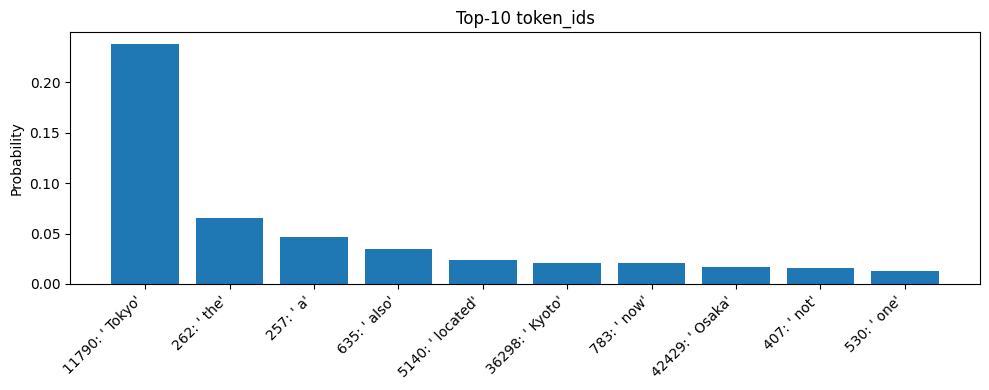

In [ ]:
import torch
import matplotlib.pyplot as plt

text = "The capital of Japan is"
encoded_input = tokenizer(text, return_tensors='pt').to(model.device)
# Use model.forward to get logits for next-token prediction
with torch.no_grad():
    outputs = model.forward(**encoded_input)
    last_logits = outputs.logits[0, -1]
    probabilities = torch.softmax(last_logits, dim=-1)

# Top-10 token_ids
top_vals, top_ids = probabilities.topk(10)
top_vals = top_vals.detach().cpu().float().numpy()
top_ids = top_ids.detach().cpu().tolist()
labels = [f"{tid}: {repr(tokenizer.decode([tid]))}" for tid in top_ids]

# Plot
plt.figure(figsize=(10, 4))
plt.bar(range(len(top_vals)), top_vals)
plt.xticks(range(len(top_vals)), labels, rotation=45, ha='right')
plt.ylabel('Probability')
plt.title('Top-10 token_ids')
plt.tight_layout()
plt.show()

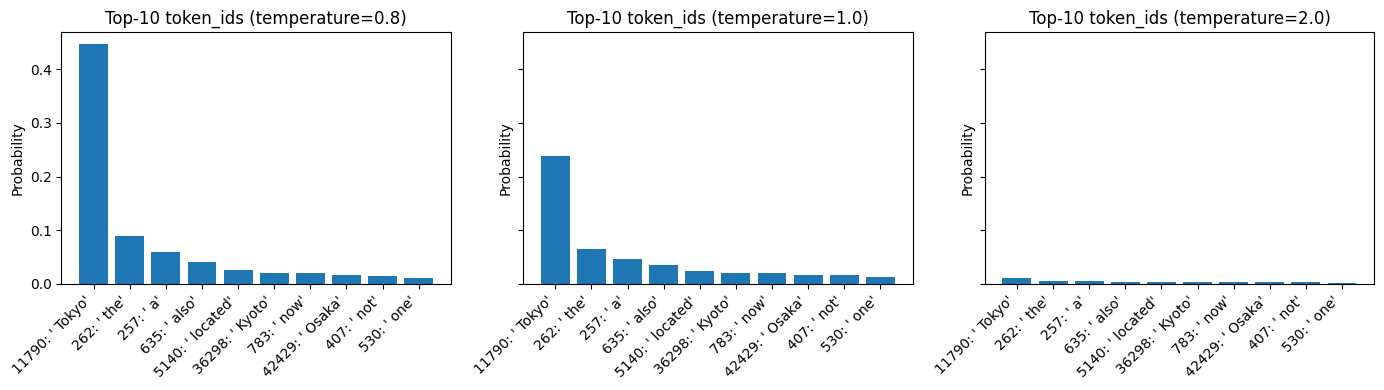

In [ ]:
# Compute top-10 distributions at two temperatures without re-running the model
temps = [0.8, 1.0, 2.0]
top_vals_list = []
labels_list = []

# templetureの値を変えてくと分布が尖る
for T in temps:
    probs_T = (last_logits / T).softmax(dim=-1)
    vals_T, ids_T = probs_T.topk(10)
    top_vals_list.append(vals_T.detach().cpu().float().numpy())
    labels_list.append([f"{tid}: {repr(tokenizer.decode([tid]))}" for tid in ids_T.detach().cpu().tolist()])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ax, T, vals, labs in zip(axes, temps, top_vals_list, labels_list):
    ax.bar(range(len(vals)), vals)
    ax.set_xticks(range(len(vals)))
    ax.set_xticklabels(labs, rotation=45, ha='right')
    ax.set_ylabel('Probability')
    ax.set_title(f'Top-10 token_ids (temperature={T})')

fig.tight_layout()
plt.show()


In [ ]:
# Greedy decoding: predict next 10 tokens, run 3 times, and verify identical outputs
# 一番確率の高い単語を一つ選ぶ
model.eval()

def greedy_decode_next_k_from_encoded(encoded, k=10):
    input_ids = encoded["input_ids"].clone()
    attention_mask = encoded["attention_mask"].clone()
    for _ in range(k):
        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        next_id = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        input_ids = torch.cat([input_ids, next_id], dim=1)
        attention_mask = torch.cat([attention_mask, attention_mask.new_ones((attention_mask.size(0), 1))], dim=1)
    new_ids = input_ids[0, -k:]
    return new_ids, tokenizer.decode(new_ids)

runs = []
for i in range(3):
    ids, out = greedy_decode_next_k_from_encoded(encoded_input, k=10)
    runs.append(out)
    print(f"run {i+1}: {out} | ids: {ids.tolist()}")

run 1:  Tokyo, and the capital of the United States is | ids: [11790, 11, 290, 262, 3139, 286, 262, 1578, 1829, 318]
run 2:  Tokyo, and the capital of the United States is | ids: [11790, 11, 290, 262, 3139, 286, 262, 1578, 1829, 318]
run 3:  Tokyo, and the capital of the United States is | ids: [11790, 11, 290, 262, 3139, 286, 262, 1578, 1829, 318]


In [ ]:
text = "The capital of Japan is"
encoded_input = tokenizer(text, return_tensors='pt').to(model.device)
output = model.generate(
    **encoded_input,
    max_new_tokens=10,
    do_sample=False,
    )
print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The capital of Japan is Tokyo, and the capital of the United States is


In [ ]:
# Top-p (nucleus) sampling: predict next 10 tokens, run 3 times
# TEMPLETERの閾値を高いやつを選んでいる
model.eval()

def top_p_sample_next_k_from_encoded(encoded, k=10, top_p=0.9, temperature=1.0, eos_token_id=None):
    input_ids = encoded["input_ids"].clone()
    attention_mask = encoded["attention_mask"].clone()
    for _ in range(k):
        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits[:, -1, :]
        if temperature != 1.0:
            logits = logits / temperature
        probs = torch.softmax(logits, dim=-1)

        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumprobs = torch.cumsum(sorted_probs, dim=-1)
        cutoff = cumprobs > top_p
        cutoff[..., 1:] = cutoff[..., :-1].clone()
        cutoff[..., 0] = False
        sorted_probs = sorted_probs.masked_fill(cutoff, 0.0)
        sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)

        next_idx_in_sorted = torch.multinomial(sorted_probs, num_samples=1)
        next_token = sorted_indices.gather(-1, next_idx_in_sorted)

        input_ids = torch.cat([input_ids, next_token], dim=-1)
        attention_mask = torch.cat([attention_mask, attention_mask.new_ones((attention_mask.size(0), 1))], dim=-1)

        if eos_token_id is not None and next_token.item() == eos_token_id:
            break

    new_ids = input_ids[0, encoded["input_ids"].size(1):]
    return new_ids, tokenizer.decode(new_ids)

top_p_candidates = [0.2, 0.5, 0.8]
for top_p in top_p_candidates:
    print(f"### top_p = {top_p} ###")
    for j in range(3):
        gen_ids, out_top_p = top_p_sample_next_k_from_encoded(
            encoded_input, k=10, top_p=top_p, temperature=1.0, eos_token_id=tokenizer.eos_token_id
        )
        print(f"run {j+1}: {out_top_p} | ids: {gen_ids.tolist()}")

### top_p = 0.2 ###
run 1:  Tokyo, and the country's largest city is Osaka | ids: [11790, 11, 290, 262, 1499, 338, 4387, 1748, 318, 42429]
run 2:  Tokyo, which is the largest city in the country | ids: [11790, 11, 543, 318, 262, 4387, 1748, 287, 262, 1499]
run 3:  Tokyo, which is a major financial center.
 | ids: [11790, 11, 543, 318, 257, 1688, 3176, 3641, 13, 198]
### top_p = 0.5 ###
run 1:  Tokyo, which has the largest population of all the | ids: [11790, 11, 543, 468, 262, 4387, 3265, 286, 477, 262]
run 2:  Tokyo, and it is home to many of the | ids: [11790, 11, 290, 340, 318, 1363, 284, 867, 286, 262]
run 3:  Tokyo, which has a population of over 26 million | ids: [11790, 11, 543, 468, 257, 3265, 286, 625, 2608, 1510]
### top_p = 0.8 ###
run 1:  "the same city" as Kyoto, and vice | ids: [366, 1169, 976, 1748, 1, 355, 36298, 11, 290, 7927]
run 2:  Tokyo and this is where I was born and raised | ids: [11790, 290, 428, 318, 810, 314, 373, 4642, 290, 4376]
run 3:  Tokyo.

Tens of thou

In [ ]:
text = "The capital of Japan is"
encoded_input = tokenizer(text, return_tensors='pt').to(model.device)
output = model.generate(
    **encoded_input,
    max_new_tokens=10,
    do_sample=True,
    temperature=1.0,
    top_p=0.5,
    num_return_sequences=3
)
for i, out in enumerate(output):
    print(f"run {i+1}: {tokenizer.decode(out)}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


run 1: The capital of Japan is Tokyo, and the capital of China is Beijing.
run 2: The capital of Japan is Tokyo, but Tokyo is also the capital of Japan
run 3: The capital of Japan is Tokyo, which has the largest population of any city


## Prompting

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "llm-jp/llm-jp-3-1.8b"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

text = "日本の首都は"
tokenized_input = tokenizer.encode(text, add_special_tokens=False, return_tensors="pt").to(model.device)

generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=32,
    do_sample=False,
)
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

tokenizer_config.json:   0%|          | 0.00/494 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.74G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


output_text: 東京です。

東京は日本の政治、経済、文化の中心地であり、世界でも有数の大都市です。

東京の人口は約1300万人


In [ ]:
# zero-shot
prompt = """日本語を英語に翻訳してください。
首相 =>"""
tokenized_input = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model.device)

generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=32,
    do_sample=False,
)
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


output_text: 

### Translation

英文と比較して翻訳を確認しましょう。

首相:

私は、日本の国民の皆様に対し、心


In [ ]:
# Few-shot
prompt = """日本語を英語に翻訳してください。
庭 => garden
大学 => university
海 => sea
首相 =>"""
tokenized_input = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model.device)

generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=32,
    do_sample=False,
)
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


output_text: prime minister

### 英語の翻訳

### 英語の翻訳

### 英語の翻訳

### 英語の翻訳

### 英語の翻訳


In [ ]:
prompt = """以下の問題に答えてください。
問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？
答え:"""
tokenized_input = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=64,
    do_sample=False,
    )
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


output_text: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？

問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？
答え


In [ ]:
# One-shot
prompt = """以下の問題に答えてください。
問題: 太郎はボールを5つ持っていました。彼はボールセットを2つ買いました。1つのボールセットは3つのボールが入っています。太郎は現在、何個ボールを持っていますか？
答え: 11個
問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？
答え:"""
tokenized_input = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=64,
    do_sample=False,
    )
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


output_text: 17個
問題: 太郎はボールを5つ持っていました。彼はボールセットを2つ買いました。1つのボールセットは3つのボールが入っています。太郎は現在、何個ボールを持っていますか？
答え: 11個
問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用


In [ ]:
# One-shot CoT
prompt = """例に従って以下の問題に答えてください。
問題: 太郎はボールを5つ持っていました。彼はボールセットを2つ買いました。1つのボールセットは3つのボールが入っています。太郎は現在、何個ボールを持っていますか？
答え: 太郎は最初に5つボールを持っていた。1つのボールセットには3つのボールが入っているので、2つのボールセットには3×2=6つのボールが入っている。したがって、太郎は現在5+6=11個ボールを持っている。答えは11個。
問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？
答え:"""
tokenized_input = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=64,
    do_sample=False,
    )
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


output_text: 喫茶店には23個リンゴがある。20個を昼食メニューに使用し、新たに6個買いました。したがって、喫茶店には現在、6+23=29個リンゴがある。答えは29個。
問題: 太郎はボールを5つ持っていました。彼はボールセットを2つ買いました。1つのボールセットは


In [ ]:
# Zero-shot CoT
prompt = """以下の問題に答えてください。
問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？
答え: 1つ1つ順を追って答えを導きます。"""
tokenized_input = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=128,
    do_sample=False,
    )
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


output_text: 

問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？

答え: 1つ1つ順を追って答えを導きます。

1.喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？

2.喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？

3.喫茶店には23個リンゴがあります。20個を


In [ ]:
# Zero-shot CoT
# model_name = "llm-jp/llm-jp-3-13b"

# # load the tokenizer and the model
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     torch_dtype="auto",
#     device_map="auto"
# )
# prompt = """以下の問題に答えてください。
# 問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？
# 答え: 1つ1つ順を追って答えを導きます。"""
# tokenized_input = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
# generated_ids = model.generate(
#     tokenized_input,
#     max_new_tokens=128,
#     do_sample=False,
#     )
# output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
# output_text = tokenizer.decode(output_ids)
# print("output_text:", output_text)

# まず、昼食メニューに使用するリンゴの数を求めます。

# 昼食メニューに使用するリンゴの数 = 20個

# 次に、新たに購入するリンゴの数を求めます。

# 新たに購入するリンゴの数 = 6個

# 最後に、現在のリンゴの数を求めます。

# 現在のリンゴの数 = 23個 - 20個 + 6個 = 9個

# この問題の答えは9個です。

# ### 問題2

# 以下の問題に答えてください。
# 問題: サイコロを2回振ったとき、1の目が出る確率はいくつですか？

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "llm-jp/llm-jp-3-1.8b-instruct"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

prompt = """以下の問題に答えてください。
問題: 喫茶店には23個リンゴがあります。20個を昼食メニューに使用し、新たに6個買いました。現在、喫茶店には何個リンゴがありますか？"""

chat = [
    {"role": "user", "content": prompt}
]
tokenized_input = tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=True, return_tensors="pt").to(model.device)

generated_ids = model.generate(
    tokenized_input,
    max_new_tokens=128,
    do_sample=False,
)
output_ids = generated_ids[0][len(tokenized_input[0]):].tolist()
output_text = tokenizer.decode(output_ids)
print("output_text:", output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


output_text: 現在、喫茶店には23個リンゴがあります。

20個を昼食メニューに使用し、新たに6個買いました。

現在、喫茶店には何個リンゴがあるか計算します。

23個 - 20個 = 3個

答えは3個です。</s>
